# Binary Classification Methods

In [1121]:
#Import Packages
import os
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn import datasets
%matplotlib inline

## 2.1: Data Cleaning, EDA, Transformations

In [1122]:
#Import the Data
train = pd.read_csv("titanic_train.csv")
test = pd.read_csv("titanic_test.csv")

In [1123]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [1124]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [1125]:
#Separate ID column to use for predictions
train_ID = train['PassengerId']
test_ID = test['PassengerId']

#Drop ID column 
train.drop("PassengerId", axis = 1, inplace = True)
test.drop("PassengerId", axis = 1, inplace = True)

It looks like we have some missing values in the Age, Cabin, and Embarked columns

In [1126]:
#Get missing value counts
train.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

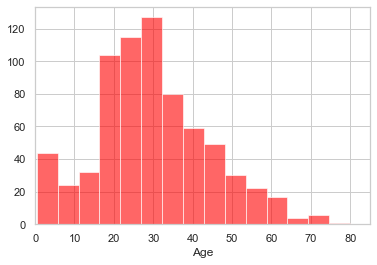

In [1127]:
#Examine Age (20% of the values are missing) to see what fill values make sense
sns.set(style="whitegrid", color_codes=True)
ax = train["Age"].hist(bins=15, stacked=True, color='red', alpha=0.6)
ax.set(xlabel='Age')
plt.xlim(0,85)
plt.show()

In [1128]:
#Median Age by Pclass
print(train[["Pclass", "Age"]].groupby("Pclass").median())
print("\n")

#Median Age by Sex
print(train[["Sex", "Age"]].groupby("Sex").median())

         Age
Pclass      
1       37.0
2       29.0
3       24.0


         Age
Sex         
female  27.0
male    29.0


It looks like we can replace the missing age values with the age medians of each Pclass. This makes more sense than replacing the missing values with the overall median of Age because there is a significant difference in ages between each class

We are going to drop the Cabin variable from the dataset. Almost 80% of the values are missing so it would make no sense to fill them with values that would make up the majority of the data points. 

For the two missing Embarked values, the NAs will be filled with the mode of the Embarked feature. 

In [1129]:
#Fill Age NAs with median of each class
train['Age'] = train['Age'].fillna(train.groupby('Pclass')['Age'].transform('median'))

In [1130]:
#Drop the Cabin variable
#We will also drop the Name and Ticket variables as they will have no effect on survival
train = train.drop(columns = ["Cabin","Name","Ticket"], axis=1)

In [1131]:
#Fill embarked NAs with the mode
train["Embarked"].fillna(train['Embarked'].value_counts().idxmax(), inplace=True)

In [1132]:
#Encode Categorical Variables
df_embarked = pd.get_dummies(train['Embarked'], 
                                     prefix='embarked')

df_sex = pd.get_dummies(train['Sex'], 
                                prefix='sex')

df_plcass = pd.get_dummies(train['Pclass'], 
                                   prefix='pclass')

In [1133]:
#Add encoded variables back to data
train_encod = pd.concat([train, 
                        df_embarked_one_hot, 
                        df_sex_one_hot, 
                        df_plcass_one_hot], axis=1)
train_encod.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,embarked_C,embarked_Q,embarked_S,sex_female,sex_male,pclass_1,pclass_2,pclass_3
0,0,3,male,22.0,1,0,7.2500,S,0,0,1,0,1,0,0,1
1,1,1,female,38.0,1,0,71.2833,C,1,0,0,1,0,1,0,0
2,1,3,female,26.0,0,0,7.9250,S,0,0,1,1,0,0,0,1
3,1,1,female,35.0,1,0,53.1000,S,0,0,1,1,0,1,0,0
4,0,3,male,35.0,0,0,8.0500,S,0,0,1,0,1,0,0,1


In [1134]:
# Drop the original categorical columns because they have been encoded
train = train_encod.drop(['Pclass', 'Sex', 'Embarked'], axis=1)
train.head()

,Survived,Age,SibSp,Parch,Fare,embarked_C,embarked_Q,embarked_S,sex_female,sex_male,pclass_1,pclass_2,pclass_3
0,0,22.0,1,0,7.2500,0,0,1,0,1,0,0,1
1,1,38.0,1,0,71.2833,1,0,0,1,0,1,0,0
2,1,26.0,0,0,7.9250,0,0,1,1,0,0,0,1
3,1,35.0,1,0,53.1000,0,0,1,1,0,1,0,0
4,0,35.0,0,0,8.0500,0,0,1,0,1,0,0,1


In [1135]:
#Split Data into Training/Test Sets
np.random.seed(42)

from sklearn.model_selection import train_test_split

Y = train["Survived"]
X = train.drop("Survived",axis=1)

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, train_size=0.8, random_state=42)
print(X_train.shape)
print(X_val.shape)

(712, 12)
(179, 12)


0    549
1    342
Name: Survived, dtype: int64


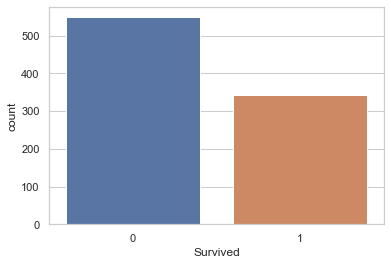

In [1136]:
#Examine target variable
sns.countplot(data=train,x='Survived')
print(train['Survived'].value_counts())

In [1137]:
#Scale the features
scaler=StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)

## 2.2: Modeling

### Logistic Regression

In [1138]:
#Logistic Regression Pipeline
pipe=make_pipeline(StandardScaler(), 
                   LogisticRegression(solver='saga',
                                     penalty='elasticnet',
                                     max_iter=10000))
pipe

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(max_iter=10000, penalty='elasticnet',
                                    solver='saga'))])

In [1139]:
#Parameter grid to use in gridsearch
param_grid=dict(
           logisticregression__C=[0.01,0.1,1.0,10.0],
            logisticregression__l1_ratio=[0,0.1,0.25,0.50,0.75,0.90,1.0])

In [1140]:
grid=GridSearchCV(pipe,param_grid=param_grid,n_jobs=-1)

In [1141]:
#Find best hyperparameter values
gridFit = grid.fit(X_train,Y_train)
gridFit.best_params_

{'logisticregression__C': 0.1, 'logisticregression__l1_ratio': 0}

These results show that the best value for C (inverse of regularization strength) is 0.1 and the L1 ratio is 0. This is the same as saying penalty=L2.

In [1142]:
#Use hyperparameter values in Logistic Regression model
Log_model = LogisticRegression(solver='saga',penalty='l2',max_iter=10000,C=0.1)
Log_model.fit(X_train_scaled,Y_train)

val_predictions = Log_model.predict(X_val_scaled)

training_score = Log_model.score(X_train_scaled,Y_train)
val_score = Log_model.score(X_val_scaled,Y_val)

print("Logistic Regression Score (Training):",training_score)
print("Logistic Regression Score (Validation):",val_score)

Logistic Regression Score (Training): 0.8089887640449438
Logistic Regression Score (Validation): 0.8100558659217877


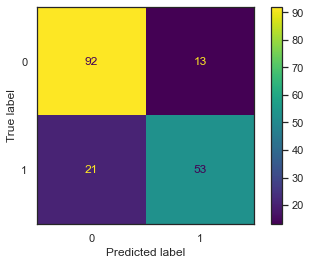

In [1143]:
#Confusion Matrix
sns.set(style="white")
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(Y_val,val_predictions)
matrix = ConfusionMatrixDisplay(confusion_matrix=cm)
matrix.plot()
plt.show()

In [1144]:
#Precision/Recall 
from sklearn.metrics import classification_report, plot_confusion_matrix, accuracy_score, precision_score, recall_score
print(classification_report(Y_val,val_predictions))

              precision    recall  f1-score   support

           0       0.81      0.88      0.84       105
           1       0.80      0.72      0.76        74

    accuracy                           0.81       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179



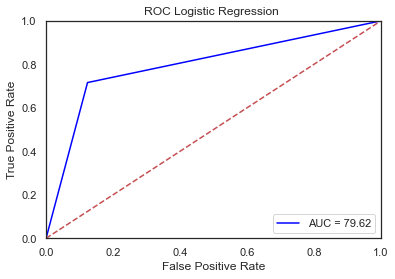

AUC:  79.62033462033462


In [1145]:
#ROC AUC Curve
from sklearn.metrics import roc_curve, auc
fp, tp, thresholds = roc_curve(Y_val, val_predictions, pos_label=1)
Auc = auc(fp, tp)*100
plt.plot(fp, tp, color='blue',label = 'AUC = %0.2f' % Auc)
plt.title('ROC Logistic Regression ')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
print("AUC: ",Auc)

We see that the model scores for Logistic Regression are consistent between the training and validation sets. Upon further inspection of the confusion matrix and precision/recall scores it becomes apparent that this model is very good at identifying passengers who did not survive, but is slightly worse at identifying survivors. This results with high precision scores for both instances (survived/not survived). The recall is very high for not survived and lower for survived, resulting in a good, but not great F1 score. The ROC shows an area under the curve of 79.62. Ideally we want this curve to be closer to the upper left hand corner of the plot. 

### Linear Discriminant Analysis (LDA)

In [1146]:
#Build LDA Model
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()

lda.fit(X_train_scaled,Y_train)

lda_predictions = lda.predict(X_val_scaled)

lda_train_score = lda.score(X_train_scaled,Y_train)
lda_val_score = lda.score(X_val_scaled,Y_val)

print("LDA Score (Training):",lda_train_score)
print("LDA Score (Validation):",lda_val_score)

LDA Score (Training): 0.8019662921348315
LDA Score (Validation): 0.7877094972067039


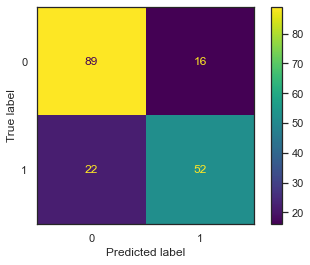

In [1147]:
#LDA Confusion Matrix
cm = confusion_matrix(Y_val,lda_predictions)
matrix = ConfusionMatrixDisplay(confusion_matrix=cm)
matrix.plot()
plt.show()

In [1148]:
#Precision/Recall 
from sklearn.metrics import classification_report, plot_confusion_matrix, accuracy_score, precision_score, recall_score
print(classification_report(Y_val,lda_predictions))

              precision    recall  f1-score   support

           0       0.80      0.85      0.82       105
           1       0.76      0.70      0.73        74

    accuracy                           0.79       179
   macro avg       0.78      0.78      0.78       179
weighted avg       0.79      0.79      0.79       179



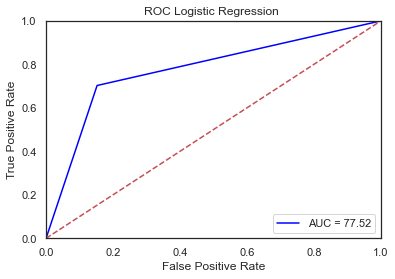

AUC:  77.51608751608752


In [1149]:
#ROC AUC Curve
fp, tp, thresholds = roc_curve(Y_val, lda_predictions, pos_label=1)
Auc = auc(fp, tp)*100
plt.plot(fp, tp, color='blue',label = 'AUC = %0.2f' % Auc)
plt.title('ROC Logistic Regression ')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
print("AUC: ",Auc)

The LDA model performs similarly to the Logistic Regression model. The confusion matrices for Logistic regression and LDA are almost identical, but the precision/recall/F1 scores for Logistic regression are slightly higher. The ROC curve confirms these values by having a lower AUC than Logistic regression. 

### KNN Classifier

In [1150]:
#Build KNN Model
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train_scaled,Y_train)

knn_predictions = knn.predict(X_val_scaled)

knn_training_score = knn.score(X_train_scaled,Y_train)
knn_val_score = knn.score(X_val_scaled,Y_val)

print("KNN Score (Training):",knn_training_score)
print("KNN Score (Validation):",knn_val_score)

KNN Score (Training): 0.8693820224719101
KNN Score (Validation): 0.8212290502793296


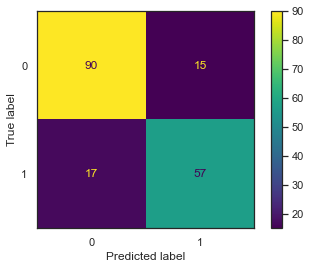

In [1151]:
#NN Confusion Matrix
cm = confusion_matrix(Y_val,knn_predictions)
matrix = ConfusionMatrixDisplay(confusion_matrix=cm)
matrix.plot()
plt.show()

In [1152]:
from sklearn.metrics import classification_report, plot_confusion_matrix, accuracy_score, precision_score, recall_score
print(classification_report(Y_val,knn_predictions))

              precision    recall  f1-score   support

           0       0.84      0.86      0.85       105
           1       0.79      0.77      0.78        74

    accuracy                           0.82       179
   macro avg       0.82      0.81      0.81       179
weighted avg       0.82      0.82      0.82       179



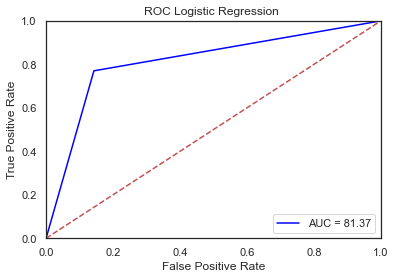

AUC:  81.37065637065636


In [1153]:
#ROC AUC Curve
fp, tp, thresholds = roc_curve(Y_val, knn_predictions, pos_label=1)
Auc = auc(fp, tp)*100
plt.plot(fp, tp, color='blue',label = 'AUC = %0.2f' % Auc)
plt.title('ROC Logistic Regression ')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
print("AUC: ",Auc)

The KNN model is our best performing model, albeit by a small margin. It follows the pattern of the previous two models by performing better when identifying passengers that did not survive. This similarity between all three models could possibly be due to a slight data imbalance; in the dataset 61.6% of passengers did not survive. This might cause the model to over-predict the number of passengers that did not survive. The ROC for KNN is the best one out of the three models, having the highest AUC. 

## 2.3 Kaggle Predictions

For Kaggle predictions, the KNN model will be used for the test set.

In [1154]:
#Perform Data transformations on test set
test['Age'] = test['Age'].fillna(test.groupby('Pclass')['Age'].transform('median'))
test = test.drop(columns = ["Cabin","Name","Ticket"], axis=1)
test["Embarked"].fillna(test['Embarked'].value_counts().idxmax(), inplace=True)
test["Fare"] = test["Fare"].fillna(test["Fare"].median())


In [1155]:
df_embarked = pd.get_dummies(test['Embarked'], 
                                     prefix='embarked')

df_sex = pd.get_dummies(test['Sex'], 
                                prefix='sex')

df_plcass = pd.get_dummies(test['Pclass'], 
                                   prefix='pclass')

In [1156]:
test_encod = pd.concat([test, 
                        df_embarked, 
                        df_sex, 
                        df_plcass], axis=1)
test = test_encod.drop(['Pclass', 'Sex', 'Embarked'], axis=1)

In [1157]:
scaler.fit(test)
test_scaled = scaler.transform(test)


In [1158]:
#KNN Classifier Predictions
KNN_predictions = knn.predict(test_scaled)

Knn_df = pd.DataFrame()
Knn_df["PassengerId"] = test_ID
Knn_df["Survived"] = KNN_predictions

In [1159]:
#Export to CSV
Knn_df.to_csv("KNN Predictions.csv",index=False)